In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2     
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 

In [27]:
tf.get_logger().setLevel('ERROR')

In [28]:
dataset_path = 'BrainTumorDataSet/Train' 
validation_path = 'BrainTumorDataSet/Test' 

img_size = (224, 224)
batch_size = 16
CLASS_WEIGHTS = {0: 1.0, 1: 1.5} 

In [29]:
try:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        validation_path,
        seed=123,
        image_size=img_size,
        batch_size=batch_size
    )
    
    val_ds_unshuffled = tf.keras.preprocessing.image_dataset_from_directory(
        validation_path,
        seed=123,
        image_size=img_size,
        batch_size=1, 
        shuffle=False 
    )
except Exception as e:
    print(f"\nFATAL ERROR: An error occurred while loading the data. Please check the following paths:")
    print(f"Training path: {dataset_path}")
    print(f"Validation path: {validation_path}")
    print(f"Error details: {e}")
    exit()

class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 589 files belonging to 2 classes.
Found 203 files belonging to 2 classes.
Found 203 files belonging to 2 classes.
نام کلاس‌ها: ['healthy', 'tumor']


In [30]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])


In [31]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds_unshuffled = val_ds_unshuffled.map(lambda x, y: (preprocess_input(x), y)) 

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_unshuffled = val_ds_unshuffled.cache().prefetch(buffer_size=AUTOTUNE) 


In [32]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3), 
    include_top=False, 
    weights="mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5" 
)

In [10]:
base_model.trainable = False

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(512, activation='relu'), 
    layers.Dropout(0.3),
    
    layers.Dense(2, activation='softmax') 
])

print("\n--- A brief summary of the model architecture (Simple and Efficient Head) ---")
model.summary()


--- خلاصه‌ای از معماری مدل (Head ساده و کارآمد) ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
print("\n--- Beginning Phase 1: Training the top layers (Head) ---")

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, 
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'), 
        ReduceLROnPlateau(patience=3, monitor='val_loss'), 
        ModelCheckpoint("mobilenet_base_optimized_simple.keras", save_best_only=True)
    ],
    class_weight=CLASS_WEIGHTS 
)


--- شروع فاز ۱: آموزش لایه‌های بالایی (Head) ---
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 570ms/step - accuracy: 0.7602 - loss: 0.6995 - val_accuracy: 0.8522 - val_loss: 0.3266 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.9080 - loss: 0.2961 - val_accuracy: 0.9803 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.9623 - loss: 0.1170 - val_accuracy: 0.9852 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.9643 - loss: 0.1238 - val_accuracy: 0.9803 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 320ms/step - accuracy: 0.9596 - loss: 0.1033 - val_accuracy: 0.9901 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.9677 - loss: 0.1000 - val_accuracy: 0.9704 - val_loss: 0.0729 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━

In [12]:
print("\n--- Beginning Phase 2: Fine-Tuning the deeper layers ---")

base_model.trainable = True

for layer in base_model.layers[:-30]: 
    layer.trainable = False
    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, 
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'), 
        ReduceLROnPlateau(patience=3, monitor='val_loss'), 
        ModelCheckpoint("mobilenet_finetuned_optimized_simple.keras", save_best_only=True)
    ],
    class_weight=CLASS_WEIGHTS
)


--- شروع فاز ۲: تنظیم دقیق (Fine-Tuning) لایه‌های عمقی ---
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 544ms/step - accuracy: 0.8474 - loss: 0.4541 - val_accuracy: 0.9803 - val_loss: 0.0454 - learning_rate: 1.0000e-05
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 430ms/step - accuracy: 0.9506 - loss: 0.1259 - val_accuracy: 0.9803 - val_loss: 0.0318 - learning_rate: 1.0000e-05
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 430ms/step - accuracy: 0.9835 - loss: 0.0632 - val_accuracy: 0.9852 - val_loss: 0.0238 - learning_rate: 1.0000e-05
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 434ms/step - accuracy: 0.9943 - loss: 0.0385 - val_accuracy: 0.9852 - val_loss: 0.0230 - learning_rate: 1.0000e-05
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 434ms/step - accuracy: 0.9968 - loss: 0.0235 - val_accuracy: 0.9901 - val_loss: 0.0190 - learning_rate: 1.0000e-05
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 1.0000 - loss: 0.0183 - val_accuracy: 0.9901 - val_loss: 0.0177 - learning_rate: 1.0000e-0

In [13]:
model.save("mobilenet_test_optimized_simple_final99.h5", include_optimizer=False)
print("\n--- Final model saved ---")


--- مدل نهایی با معماری ساده‌تر ذخیره شد ---


In [14]:
print("\n--- 6. Final evaluation for extracting errors and probabilities ---")

y_true = []
all_preds_prob = []

for images, labels in val_ds_unshuffled:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    all_preds_prob.extend(preds)

y_pred_default = np.argmax(all_preds_prob, axis=1)
print("\nConfusion Matrix - Threshold 0.5:")
print(confusion_matrix(y_true, y_pred_default))

print("\nClassification Report - Threshold 0.5:")
print(classification_report(y_true, y_pred_default, target_names=class_names))


--- ۶. ارزیابی نهایی برای استخراج خطاها و احتمالات ---

ماتریس درهم ریختگی (Confusion Matrix) - آستانه ۰.۵:
[[104   0]
 [  1  98]]

گزارش طبقه‌بندی (Classification Report) - آستانه ۰.۵:
              precision    recall  f1-score   support

     healthy       0.99      1.00      1.00       104
       tumor       1.00      0.99      0.99        99

    accuracy                           1.00       203
   macro avg       1.00      0.99      1.00       203
weighted avg       1.00      1.00      1.00       203



In [15]:
OPTIMAL_THRESHOLD = 0.30
print(f"\n--- 7. Evaluation with Optimized Decision Threshold ({OPTIMAL_THRESHOLD}) ---")
y_pred_thresholded = []
all_preds_prob_array = np.array(all_preds_prob)

tumor_probabilities = all_preds_prob_array[:, 1]
y_pred_thresholded = (tumor_probabilities >= OPTIMAL_THRESHOLD).astype(int)

print(f"\nConfusion Matrix - Threshold {OPTIMAL_THRESHOLD}:")
print(confusion_matrix(y_true, y_pred_thresholded))

print(f"\nClassification Report - Threshold {OPTIMAL_THRESHOLD}:")
print(classification_report(y_true, y_pred_thresholded, target_names=class_names))


--- ۷. ارزیابی با آستانه تصمیم‌گیری بهینه شده (0.3) ---

ماتریس درهم ریختگی (Confusion Matrix) - آستانه 0.3:
[[103   1]
 [  0  99]]

گزارش طبقه‌بندی (Classification Report) - آستانه 0.3:
              precision    recall  f1-score   support

     healthy       1.00      0.99      1.00       104
       tumor       0.99      1.00      0.99        99

    accuracy                           1.00       203
   macro avg       0.99      1.00      1.00       203
weighted avg       1.00      1.00      1.00       203



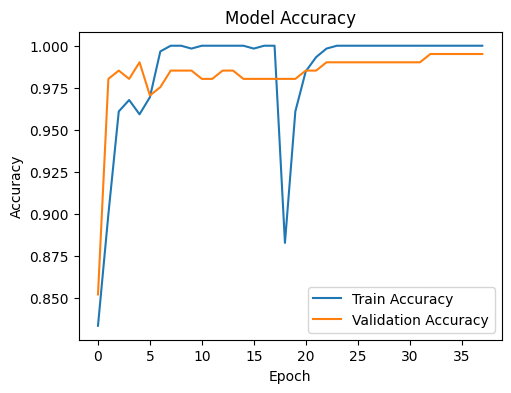

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

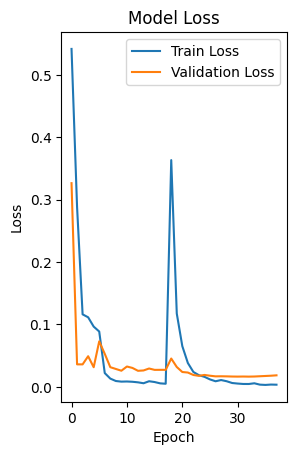

In [20]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()